# About this notebook 

We will walk you through the intuition and underlying theory in our debiasing method by using a concrete network example. You can find our paper here:
> (name) (title) (venue) (year)

## Set up

In [31]:
%%capture
!pip install git+https://github.com/skojaku/graphvec.git
!pip install residual2vec

In [32]:
import numpy as np
from scipy import sparse
import pandas as pd
import residual2vec
import graphvec
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

# Network

We use the political book network to showcase the effectiveness of our debiasing method.  

In [33]:
G = nx.read_gml("data/polbooks.gml")
G = nx.relabel.convert_node_labels_to_integers(
    G, first_label=0, ordering="default"
)  # first_label is the starting integer label, in this case zero


#
# Randomize the graph by dcSBM
#
nodes = G.nodes(data=True)
labels, group_ids = np.unique([nd[1]["value"] for nd in nodes], return_inverse=True)
A = nx.adjacency_matrix(G).asfptype()

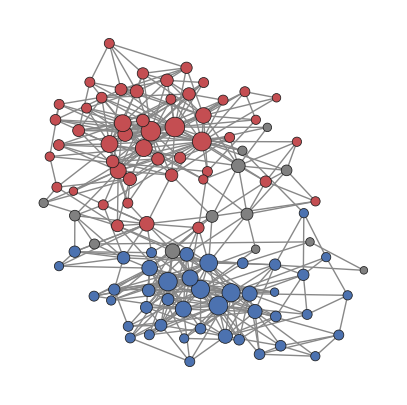

In [55]:
# Layout
pos = nx.layout.kamada_kawai_layout(G)
xys = np.vstack([p for p in pos.values()])
deg = np.array(A.sum(axis=1)).reshape(-1)

# Plot
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5, 5))

cmap = {
    "c": sns.color_palette()[3],
    "l": sns.color_palette()[0],
    "n": "grey",
}
cmap = {i: cmap[c] for i, c in enumerate(cmap.keys())}

nx.draw_networkx_edges(G, pos, edge_color="#888", ax=ax)
sns.scatterplot(
    x=xys[:, 0],
    y=xys[:, 1],
    hue=group_ids,
    size=deg,
    sizes=(30, 200),
    palette=cmap,
    edgecolor="k",
    ax=ax,
)
# ax.axis("off")
ax.legend().remove()
ax.axis("off")
fig.savefig("network.pdf", bbox_inches='tight', dpi=300)

# Biases in embedding 

In the political book network, each book is more likely to be connected with other books with the same political leaning, i.e., political homophily. Because the political homophily is so strong, they can also appear in the graph embedding as the most prominent dimension. We will first demonstrate by using a node2vec trained for link prediction.


Link prediction is a classification problem, where one is given a set of node pairs and classifies them into connected and unconnected node pairs. With the graph embedding, the prediction is based on the distance between two nodes, namely a simple prediction is to predict two closer nodes in an embedding to have a higher chance of being connected. The given node pairs consist of the connected node pairs sampled from the given network, together with the unconnected nodes that are also sampled from the given network. The unconnected node pair is composed of two nodes, each of which is sampled uniformly at random from the given network. 


node2vec is inherently trained to differentiate the connected node pairs and randomly-paired nodes. For link prediction, we sample the randomly-paired nodes in the same way as the link prediction benchmark samples the unconnected node pairs, in order to yield the maximum link prediction performance (which is indeed a good way to increase it).


In [35]:
import residual2vec as rv

#noise_sampler = rv.SBMNodeSampler(group_membership = group_ids, dcsbm=False,window_length=1)  # sampler for the negative sampling
noise_sampler = rv.ErdosRenyiNodeSampler()  # sampler for the negative sampling
model = rv.residual2vec_sgd(
    noise_sampler, window_length=1, num_walks = 80, learn_joint_probability=True
)
model.fit(A)
emb_uniform = model.transform(dim=64)

100%|██████████| 1313/1313 [00:05<00:00, 240.13it/s, loss=0.312]


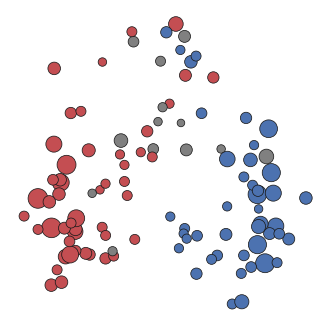

In [36]:
# Layout
from sklearn.decomposition import PCA

xys = PCA(n_components=2).fit_transform(emb_uniform)

# %%
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    x=xys[:, 0],
    y=xys[:, 1],
    hue=group_ids,
    size=deg,
    sizes=(30, 200),
    palette=cmap,
    edgecolor="k",
    ax=ax,
)
ax.legend().remove()
ax.axis("off")
fig.savefig("emb-unbiased.pdf", bbox_inches='tight', dpi=300)

In the generated embedding, each book is closer to other books with the same political leaning, reflecting the political homophily.  The x-axis corresponds to the spectrum of political leaning from conservative to liberal. Given that the x-axis corresponds to the principal component of the embedding, the political leaning is learned as the most important dimension by node2vec. 

# How bias enters node2vec 

Why did node2vec learn the political homophily? node2vec is trained to discriminate the positive examples of connected nodes and negative examples of unconnected nodes. The fact that the political leaning is the most important dimension suggests that the positive and negative examples can be easily distinguishable by focusing on the political leaning of two nodes. To see if this is the case, let us compare the distribution of political leanings for the positive and negative examples.  

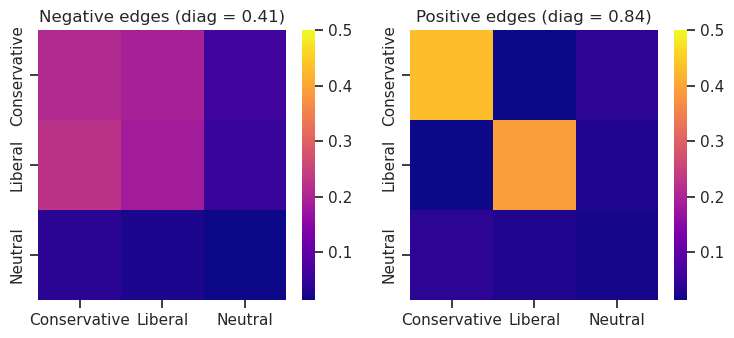

In [37]:
# Samping positive edges
src, trg, _ = sparse.find(A)

# Sampling negative edges
rand_src, rand_trg = noise_sampler.sampling(size=len(src))

# Joint distribution of political leaning
edge_table = pd.DataFrame(
    {
        "src": np.concatenate([src, rand_src]),
        "trg": np.concatenate([trg, rand_trg]),
        "edgeType": (["Positive"] * len(src)) + (["Negative"] * len(rand_src)),
    }
)

sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(8.8, 3.5), ncols=2)

tickLabels = [{"l": "Liberal", "c": "Conservative", "n": "Neutral"}[l] for l in labels]

for i, (edgeType, df) in enumerate(edge_table.groupby("edgeType")):
    src, trg = group_ids[df["src"]], group_ids[df["trg"]]
    S = sparse.csr_matrix(
        (np.ones_like(src), (src, trg)), shape=(len(labels), len(labels))
    ).toarray()
    S = S / np.sum(S)
    assort = np.sum(np.diag(S))
    ax = sns.heatmap(
        S,
        ax=axes[i],
        cmap="plasma",
        vmax=np.max(0.5),
        xticklabels=tickLabels,
        yticklabels=tickLabels,
        #cbar = i == 1
    )
    ax.set_title(f"{edgeType} edges (diag = {assort:.2f})")
fig.savefig("pos-vs-neg.pdf", bbox_inches='tight', dpi=300)

As the political homophily suggests,  most positive edges connect books with the same political leaning. On the other hand, negative edges are uniformly distributed. This misalignment in the political homophily is picked up by the graph embedding and used as a useful feature to differentiate the positive and negative edges. 

# Debiasing with bias sampling 

To prevent the bias from entering the embedding, we must sample the negative edges with the same bias as the positive edges. Here, we use the stochastic block model to generate the negative examples.  

In [38]:
noise_sampler = rv.SBMNodeSampler(group_membership = group_ids, dcsbm=False,window_length=1)  # sampler for the negative sampling

This sampler generates the negative examples with the same political homophily as the given network. 

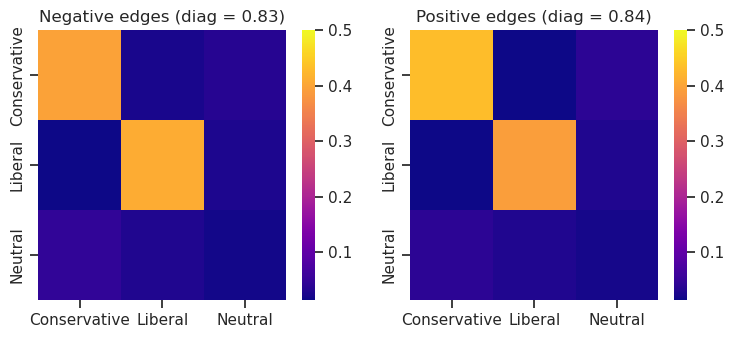

In [39]:
src, trg, _ = sparse.find(A)

# Sampling negative edges
noise_sampler.fit(A)
rand_src, rand_trg = noise_sampler.sampling(size=len(src))

# Joint distribution of political leaning
edge_table = pd.DataFrame(
    {
        "src": np.concatenate([src, rand_src]),
        "trg": np.concatenate([trg, rand_trg]),
        "edgeType": (["Positive"] * len(src)) + (["Negative"] * len(rand_src)),
    }
)

sns.set_style("white")
sns.set(font_scale=1)
sns.set_style("ticks")
fig, axes = plt.subplots(figsize=(8.8, 3.5), ncols=2)

tickLabels = [{"l": "Liberal", "c": "Conservative", "n": "Neutral"}[l] for l in labels]

for i, (edgeType, df) in enumerate(edge_table.groupby("edgeType")):
    src, trg = group_ids[df["src"]], group_ids[df["trg"]]
    S = sparse.csr_matrix(
        (np.ones_like(src), (src, trg)), shape=(len(labels), len(labels))
    ).toarray()
    S = S / np.sum(S)
    assort = np.sum(np.diag(S))
    ax = sns.heatmap(
        S,
        ax=axes[i],
        cmap="plasma",
        vmax=np.max(0.5),
        xticklabels=tickLabels,
        yticklabels=tickLabels,
        #cbar = i == 1
    )
    ax.set_title(f"{edgeType} edges (diag = {assort:.2f})")
fig.savefig("pos-vs-neg-biased.pdf", bbox_inches='tight', dpi=300)
# fig.savefig(output_file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

Now, let's train again the node2vec with the biased negative examples. 

In [40]:
import residual2vec as rv

model = rv.residual2vec_sgd(
    noise_sampler, window_length=1, num_walks = 80, learn_joint_probability=True
)
model.fit(A)
emb_deb = model.transform(dim=64)


100%|██████████| 1313/1313 [00:05<00:00, 252.53it/s, loss=0.535]


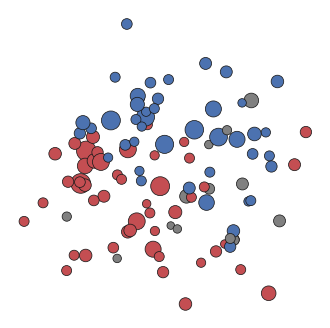

In [41]:
# Layout
from sklearn.decomposition import PCA

xys = PCA(n_components=2).fit_transform(emb_deb)

# %%
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(4, 4))

sns.scatterplot(
    x=xys[:, 0],
    y=xys[:, 1],
    hue=group_ids,
    size=deg,
    sizes=(30, 200),
    palette=cmap,
    edgecolor="k",
    ax=ax,
)
ax.legend().remove()
ax.axis("off")
# fig.savefig(output_file, bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)
# Samping positive edges
fig.savefig("emb-biased.pdf", bbox_inches='tight', dpi=300)


The political leaning becomes less pronounced in the embedding.  

/home/skojaku/anaconda3/envs/residual2vec_/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


952 882.0
854 882


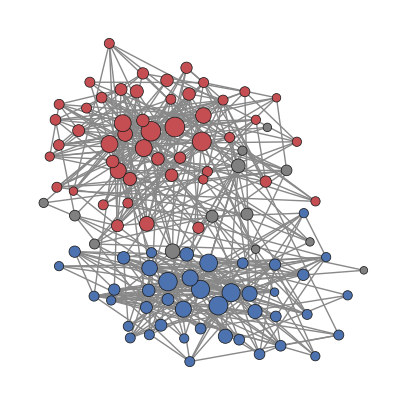

In [60]:
# Plot
sns.set_style("white")
sns.set(font_scale=1.2)
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(5, 5))

cmap = {
    "c": sns.color_palette()[3],
    "l": sns.color_palette()[0],
    "n": "grey",
}
cmap = {i: cmap[c] for i, c in enumerate(cmap.keys())}

n_nodes = A.shape[0]
Arand = sparse.triu(sparse.csr_matrix((np.ones_like(rand_src), (rand_src, rand_trg)), shape=(n_nodes, n_nodes)))
Arand = Arand + Arand.T
Arand.setdiag(0)
Arand.eliminate_zeros()
print(Arand.sum(), A.sum())
print(len(Arand.data), len(A.data))

xys = np.vstack([p for p in pos.values()])
Grand = nx.from_scipy_sparse_array(Arand)

nx.draw_networkx_edges(Grand, pos, edge_color="#888", ax=ax)
sns.scatterplot(
    x=xys[:, 0],
    y=xys[:, 1],
    hue=group_ids,
    size=deg,
    sizes=(30, 200),
    palette=cmap,
    edgecolor="k",
    ax=ax,
)
# ax.axis("off")
ax.legend().remove()
ax.axis("off")
fig.savefig("rand-network.pdf", bbox_inches='tight', dpi=300)